# Use Jupyter notebooks to keep track of what you did and where you've been.

I use notebooks to keep track of any fiddling I've done so I can

- look at it later.
- do it again, maybe.
- show it to others, etcetera.

The notebooks can be Python, Bash, R, Julia, Node, Python with R mixed inside (tricky!),
and lots of other options I haven't yet tried.

## You can use notebooks as notebooks to keep notes of your thoughts, observations and experiments.

<img src="galileo_jupiter.jpeg"/>

<img src="darwin_tree.jpg"/>

<img src="rosalind franklin's notebook on dna.jpg"/>

## Later you can extract stuff from the notebooks and polish them into publications of various kinds.

A real life example:

I used a notebook to explore data from Nick for the
[http://localhost:8888/notebooks/misc/nick_deveaux/data%20experiment.ipynb](dendritic cell project).

I later hardened these code fragments into  
[the `dc_network` repository](https://github.com/flatironinstitute/dc_network)
published using Binder.

## A somewhat real example follows.

### I developed an implementation of least absolute error linear regression using the linear programming functionality provided by scipy.

The method is not new but as far as I can tell no one has published it as
a Python module.

### I used notebook experimentation to try out the method with different inputs with visualization for debugging.

# Least absolute error regression: the code and visualization

## This is a cleaned up version of a computational experiment captured as a Jupyter notebook.

## This is the *Notebook proof of concept* which we want to harden into a *Published module* suitable for use by other professionals.

In [1]:
import numpy as np
import scipy.optimize

def l1_fit(U, v):
    """
    Find a least absolute error solution (m, k) to U * m + k = v + e.
    Minimize sum of absolute values of vector e (the residuals).
    """
    U = np.array(U)
    v = np.array(v)
    # n is the number of samples
    n = len(v)
    s = U.shape
    assert len(s) == 2
    assert s[0] == n
    # d is the number of dimensions
    d = s[1]
    I = np.identity(n)
    n1 = np.ones((n,1))
    A = np.vstack([
            np.hstack([-I, U, n1]),
            np.hstack([-I, -U, -n1])
        ])
    c = np.hstack([np.ones(n), np.zeros(d+1)])
    b = np.hstack([v, -v])
    bounds = [(0, None)] * n + [(None, None)] * (d+1)
    options = {"maxiter": 10000}
    # Call the linprog subroutine.
    r = scipy.optimize.linprog(c, A, b, bounds=bounds, options=options)
    # Extract the interpolation result from the linear program solution.
    x = r.x
    m = x[n:n+d]
    k = x[n+d]
    v_predicted = np.dot(U, m) + k
    residuals = v - v_predicted
    # For debugging store all parameters, intermediates and results in returned dict.
    result = {}
    result["U"] = U
    result["v"] = v
    result["m"] = m
    result["k"] = k
    result["r"] = r
    result["samples"] = n
    result["dimensions"] = d
    result["A"] = A
    result["b"] = b
    result["c"] = c
    result["bounds"] = bounds
    result["residuals"] = residuals
    result["v_predicted"] = v_predicted
    return result

I also modified a matplotlib illustration for simple regression to illustrate the
method.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt


def lsqfit(x, y):
    "least squares fit, for comparison"
    x = np.array(x)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    fity = m*x + c
    return fity

def plot(result, size=64):
    samples = result["samples"]
    dimensions = result["dimensions"]
    # this plot only works for linear fits
    assert dimensions == 1, "sorry, no can do"
    U = result["U"]
    m = result["m"]
    x = U.reshape((samples,))
    y_actual = result["v"]
    y_predicted = result["v_predicted"]
    y_least_squares = lsqfit(x, y_actual)
    fig, ax = plt.subplots()
    ax.scatter(x, y_actual, facecolors='none', edgecolors='b', s=size)
    #ax.scatter(x, y_predicted, color="red", marker="x", s=size)
    ax.plot(x, y_least_squares, color="green", dashes=(5,5))
    ax.plot(x, y_predicted, color="red")
    fig.show()

## Trivial example usage

The most trivial example of regression has one dependent variable $x$ and
one independent variable $y$ and there are two samples

Here we "regress" two points mapping
```
1 --> 0
2 --> 1
```
and we expect to get the fitted formula

$$ y = m * x + k $$

where $ m = 1 $ and $ k = -1 $.

In [3]:
# Let's make the numbers more easy to read...
%precision 3

# Trivial example usage
# Independent variable values.
U = ([1], [2])
# Dependent variable values
v = (0, 1)
# Perform the regression.
result = l1_fit(U, v)
result["m"], result["k"], result["residuals"], result["samples"], result["dimensions"]

(array([ 1.]), -1.000, array([ 0.,  0.]), 2, 1)

Above note that the independent values is a sequence of lists because in general
there may be more than one independent value.

For one dimensional examples we have a helper which will show how the fit
compares to a scatter plot of the input mappings.

//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


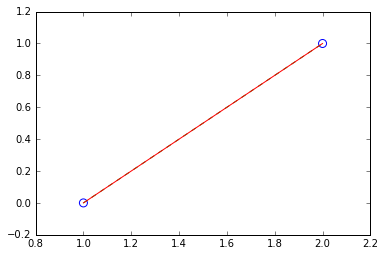

In [4]:
plot(result)

The plot shows the two input points as blue circles, the fit line in red
and a least squares fit line (which agrees in this case) in dashed green.

## A less trivial example

Regression is more interesting when you are fitting more samples than dimensions
that are not linearly related.
Below we fit one dependent variable with the mapping
```
1 --> 0
2 --> 0
3 --> 1
```

(array([ 0.5]), -0.500, array([ 0. , -0.5,  0. ]), 3, 1)

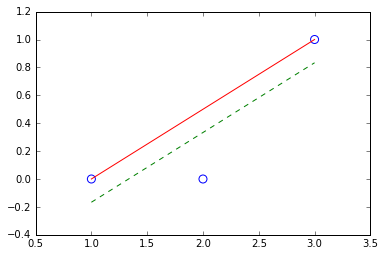

In [5]:
# Less trivial example usage
# Independent variable values
U = ([1], [2], [3])
# Dependent variable values
v = (0, 0, 1)
result = l1_fit(U, v)
plot(result)
result["m"], result["k"], result["residuals"], result["samples"], result["dimensions"]

In this case the least squared error fit and the least absolute error fit
do not agree.

## Many independent variable

The method will work with any number of independent variables.

Below we have a two independent variables mapping
```
(1,0) --> -1
(2,1) --> 1
(3,0) --> 1
```
This trivially fits the plane equation $ x + y - 2 = z $.  A "plot" of
the regression would require a 3 dimensional presentation, which is not
implemented here.

In [6]:
# A trivial example with 2 predictor variables x + y - 2
U = ([1, 0], [2, 1], [3, 0])
v = (-1, 1, 1)
result = l1_fit(U, v)
result["m"], result["k"], result["residuals"], result["samples"], result["dimensions"]

(array([ 1.,  1.]),
 -2.000,
 array([  0.000e+00,  -2.220e-16,   6.661e-16]),
 3,
 2)

Note that the we recover the equation $ 1x + 1y - 2 = z $ and all the residuals
are very near 0.

Below is a less trivial example with 2 independent variables that do not fit a plane.
The mapping of independent variables to the dependent variable is
```
(1,1) --> 0
(1,-1) --> -2
(-1,-1) --> -4
(-1,1) --> -2
(0,0) --> -1.3
```
All but the last mapping fit the plane $x + y - 2 = z$.

In [7]:
# A non trivial example with 2 predictor variables x + y - 2 and one outlier
U = ([1, 1], [1, -1], [-1, -1], [-1, 1], [0, 0])
v = (0, -2, -4, -2, -1.3)
result = l1_fit(U, v)
result["m"], result["k"], result["residuals"], result["samples"], result["dimensions"]

(array([ 1.,  1.]),
 -2.000,
 array([ -4.441e-16,  -1.332e-15,  -4.441e-16,   4.441e-16,   7.000e-01]),
 5,
 2)

Here with $m = (1,1)$ and $k = -2$ the regression finds the plane
$1*x + 1*y - 2 = z$ and essentially rejects the last mapping as an
outlier.

Note that all the residuals are near zero except for the last which has
essentially been rejected as an outlier.

Least absolute error regression is thought to be "better for ignoring outliers"
than other methods such as least squared error regression.

The example below illustrates how least squares regression (green) is more strongly
effected by outliers than least absolute error regression (red).

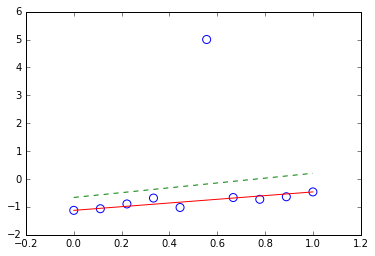

In [8]:
# nearly linear with an outlier
n = 10
x = np.linspace(0,1,n)
small_error = (np.random.randn(n)-0.5) * 0.1
y = (0.5 * x - 1) + small_error
y[5] = 5 # outlier!

U = x.reshape((n, 1))
v = y
result = l1_fit(U, v)
plot(result)

Note that most of the points are very near the least absolute error line
except for the single outlier which pulls the least squared error line away.

For more random data sets the two fit methods can disagree strongly.  Here is
a random example with on independent variable.

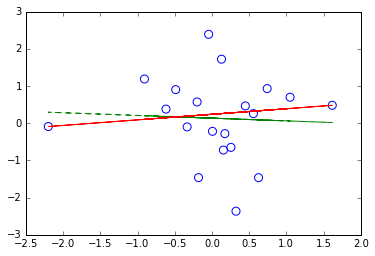

In [9]:
# a random 1d example
n = 20
x = np.random.randn(n)
y = np.random.randn(n)
U = x.reshape((n, 1))
v = y
result = l1_fit(U, v)
plot(result)

# So now that it works, how do I publish it and make other people interested in it?